# VAE Evaluation Notebook
This notebook loads a trained BetaVAE and evaluates reconstructions, KL, and latent traversals.


In [1]:
from src.vae.evaluate_run import load_vae, val_loader_from_yaml, basic_metrics, mu_variance, plot_recon, latent_traverse, pca_traverse

# Set paths

project_name = 'celebA-vae'
run_name = 'beta0-baseline-onecycle'

run_dir = f'runs/{project_name}/{run_name}'

/home/tonso/code/00--research/latent-reason/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Prepare validation loader

vae, train_cfg, device = load_vae(run_dir)

# pick the 'val' split from the same data.yaml you used to train
in_ch     = vae.config.encoder.in_channels
img_size  = vae.config.img_size
data_yaml = train_cfg['data_yaml']
bs        = train_cfg['batch_size']

val_loader = val_loader_from_yaml(
    data_yaml = data_yaml,
    img_size  = img_size,
    in_ch     = in_ch,
    bs        = bs
)


In [3]:
# Basic MSE and KL metrics
basic_metrics(vae, val_loader, device)


MSE(x, recon_mu):   0.028439
MSE(x, recon_zero): 0.436743
True KL  (mean):    11206.023438
Budgeted KL (mean): 11206.023438



In [4]:
# μ‐variance across validation set
# mus = mu_variance(vae, val_loader, device)


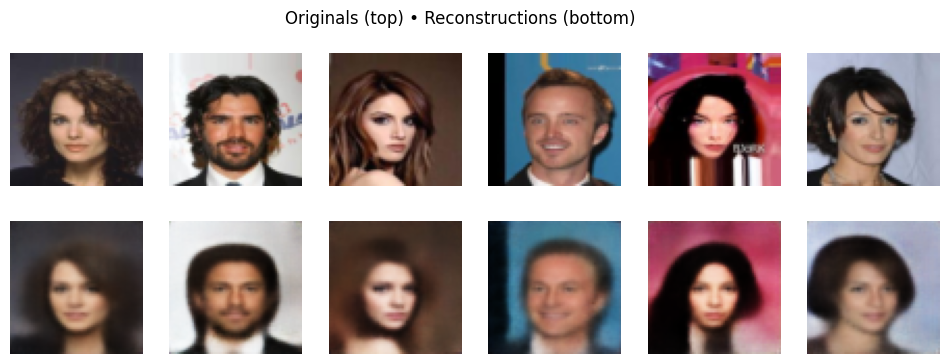

In [5]:
# Plot reconstructions
plot_recon(vae, val_loader, device, n=6)


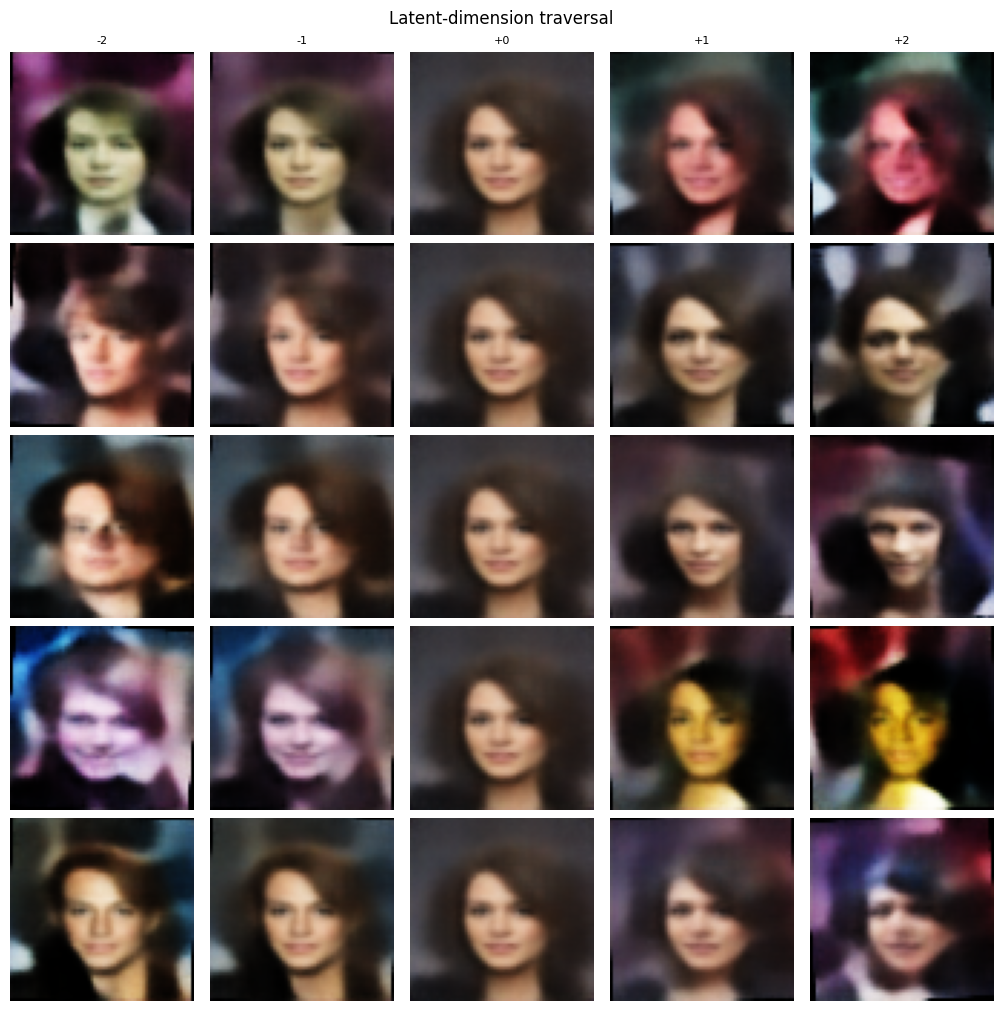

In [ ]:
# Latent dimension traversal
latent_traverse(
    vae, val_loader, device, 
    dims=5, scale=3.0
    )


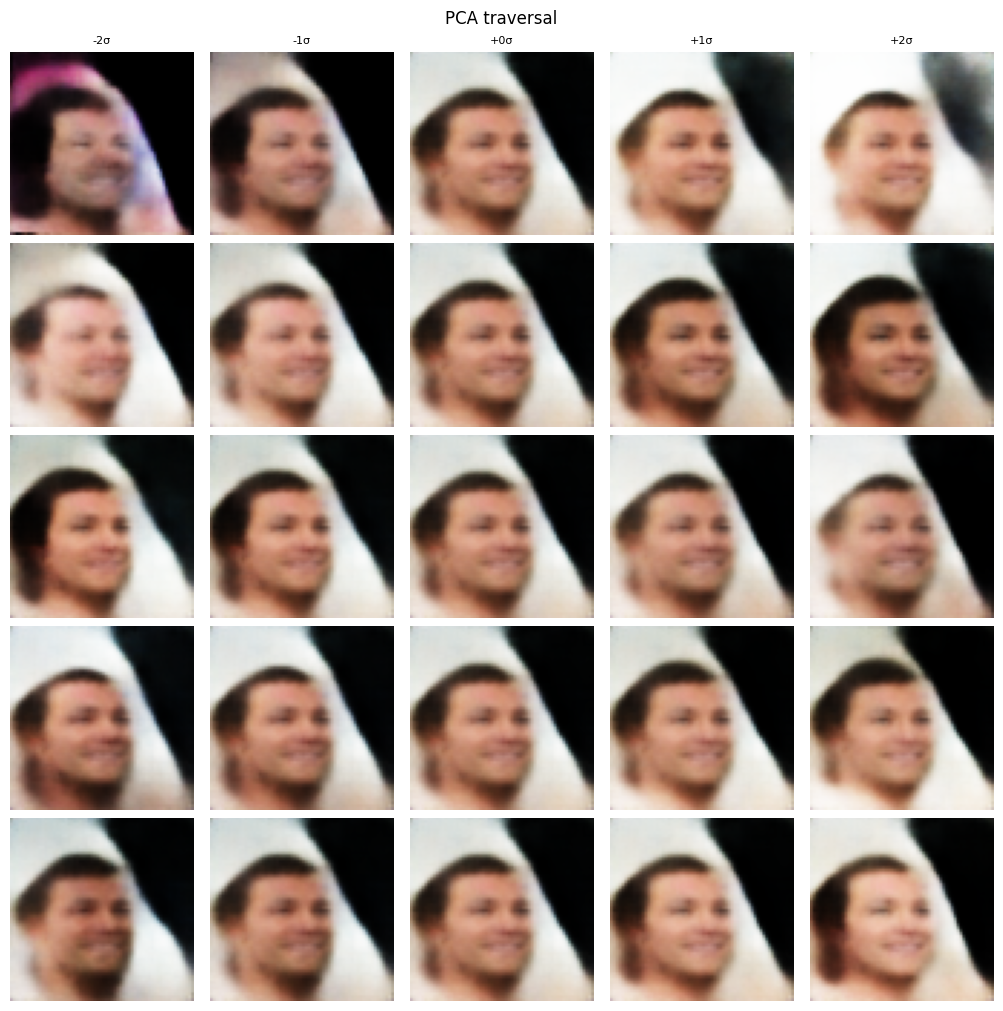

In [7]:
# PCA-based traversal
pca_traverse(
    vae, val_loader, device, 
    n_pcs=5, scale=1.0
    )


In [8]:
from src.vae.evaluate_run import (
    get_all_latents, compute_latent_stats,
    plot_pca_3d_interactive, posterior_histogram, 
    plot_latent_stats_heatmap
)

mu, logvar = get_all_latents(vae, val_loader, device)
stats      = compute_latent_stats(mu, logvar)


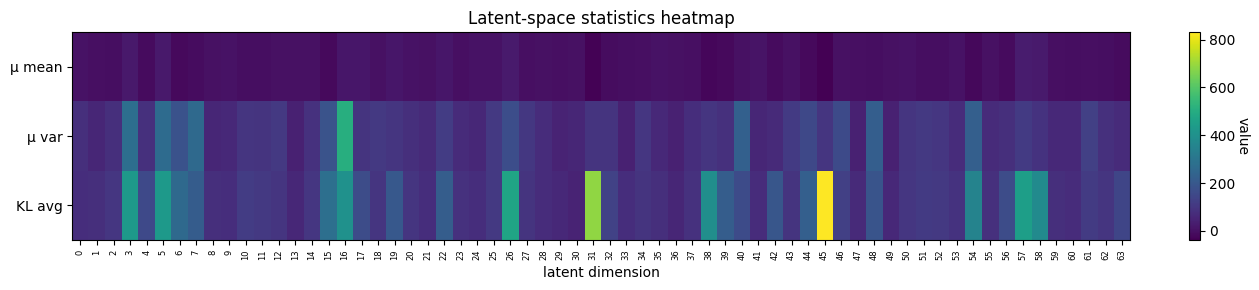

In [9]:
plot_latent_stats_heatmap(stats)



In [10]:
plot_pca_3d_interactive(mu)


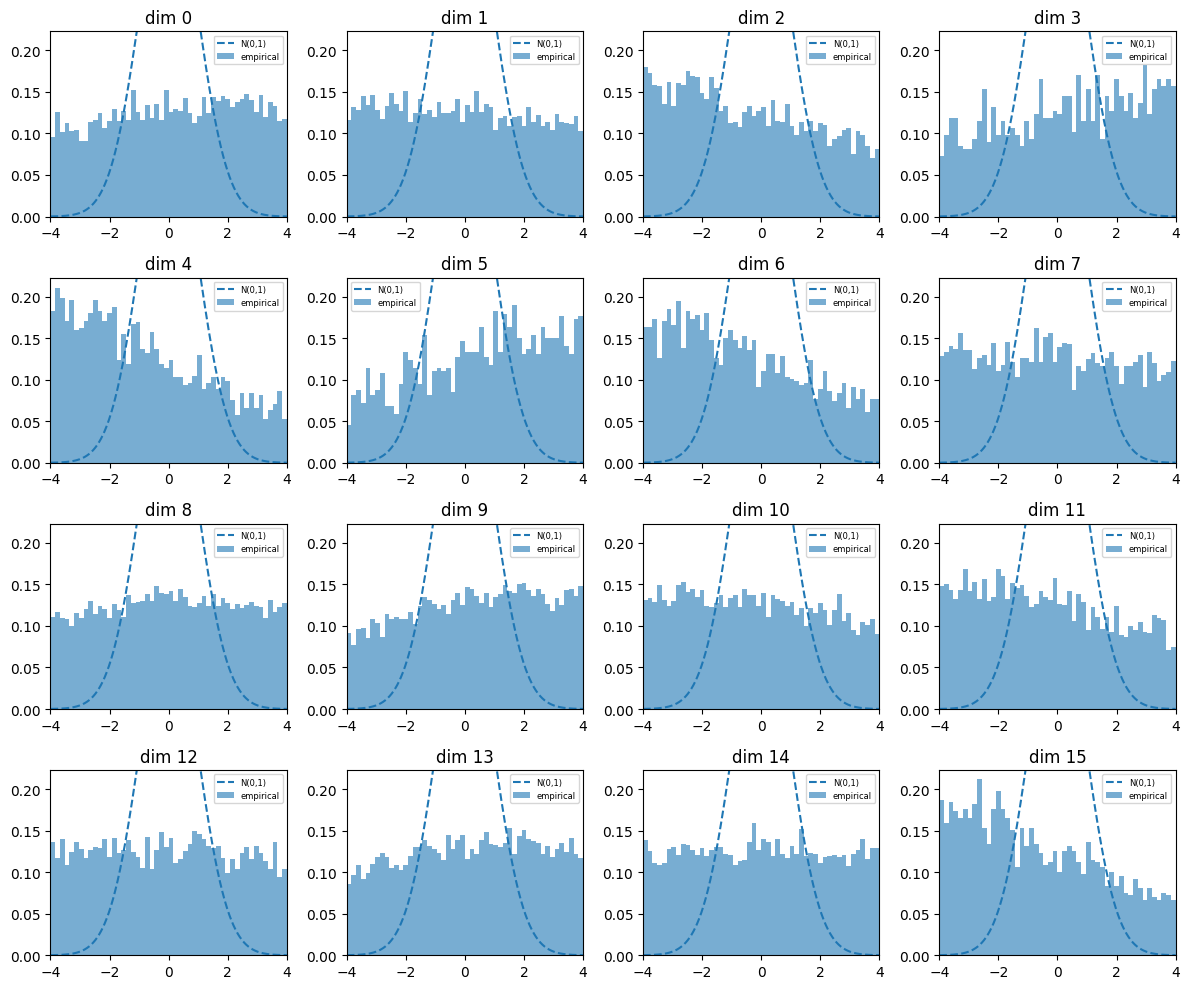

In [11]:
posterior_histogram(mu, max_dims=16)


In [12]:
# # Updated script with tqdm, minimal comments, and typing

# import argparse
# from pathlib import Path
# from typing import Literal, Tuple

# import numpy as np
# import torch
# from tqdm.auto import tqdm
# from torch.utils.data import DataLoader

# # assume these are already imported/available:
# # BetaVAE, ReconstructionDataset
# # load_vae, val_loader_from_yaml
# # basic_metrics, mu_variance, plot_recon, latent_traverse, pca_traverse

# def save_latents(
#     vae: BetaVAE,
#     dataset: ReconstructionDataset,
#     split: Literal["train", "val", "test"],
#     batch_size: int = 128,
#     num_workers: int = 4,
#     device: torch.device | str = "cuda",
# ) -> None:
#     vae.eval()
#     loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
#                         num_workers=num_workers, pin_memory=True)
#     mus, sigmas = [], []
#     for xb, _ in tqdm(loader, desc=f"Encoding latents [{split}]", leave=False):
#         xb = xb.to(device)
#         mu, logvar = vae.encoder(xb)
#         mus.append(mu.cpu().numpy())
#         sigmas.append(torch.exp(0.5 * logvar).cpu().numpy())
#     mu_arr = np.concatenate(mus, axis=0)
#     sigma_arr = np.concatenate(sigmas, axis=0)
#     out_dir = Path(vae.run_dir) / "latent" / split
#     out_dir.mkdir(parents=True, exist_ok=True)
#     np.save(out_dir / "mu.npy", mu_arr)
#     np.save(out_dir / "sigma.npy", sigma_arr)
#     print(f"Saved latents [{split}] → {out_dir}")

# def load_latents(
#     project_dir: str,
#     split: Literal["train", "val", "test"],
# ) -> Tuple[np.ndarray, np.ndarray]:
#     d = Path(project_dir) / "latent" / split
#     return np.load(d / "mu.npy"), np.load(d / "sigma.npy")

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument("run_dir", help="runs/<project>/<run_name>")
#     args = parser.parse_args()

#     vae, train_cfg, device = load_vae(args.run_dir)
#     val_loader = val_loader_from_yaml(
#         data_yaml=train_cfg["data_yaml"],
#         bs=train_cfg["batch_size"],
#         img_size=vae.config.img_size,
#         in_ch=vae.config.encoder.in_channels,
#     )

#     save_latents(vae, val_loader.dataset, split="val",
#                  batch_size=train_cfg["batch_size"],
#                  num_workers=4, device=device)

#     mu_all, sigma_all = load_latents(args.run_dir, "val")
#     mu_mean = mu_all.mean(axis=0)
#     mu_std  = mu_all.std(axis=0)
    
#     print("\n== Latent traversal ==")
#     latent_traverse(vae, val_loader, device, dims=3, steps=[-3,-1,0,1,3], mu_std=mu_std)
#     print("\n== PCA traversal ==")
#     pca_traverse(vae, val_loader, device, n_pcs=3, steps=[-3,-1,0,1,3])
